In [1]:
from scipy import special as sp
import numpy as np
import matplotlib.pyplot as plt
import miepython
import pandas as pd
import csv

/home/niya/.local/lib/python3.6/site-packages/numba/core/errors.py:154: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


## Importing data

In [2]:
# Imports wavelength and index of refraction data from a csv file

def import_data(filename): # filename with quotations
    
    df = pd.read_csv(filename, sep = ',')

    # Read values of wavelength and index of refraction

    ref_lam = df.iloc[0:,0]
    ref_n = df.iloc[0:,1]   # real index of refraction
    ref_k = df.iloc[0:,2]   # complex index of refraction

    # Convert data into arrays

    ref_lam = ref_lam.to_numpy()
    ref_n = ref_n.to_numpy()
    ref_k = ref_k.to_numpy()
    
    return ref_lam, ref_n, ref_k

In [3]:
# Import data for aluminium (Al)
# from https://refractiveindex.info/?shelf=main&book=Al&page=McPeak
ref_lam, ref_n, ref_k = import_data("McPeak_aluminium.csv")

In [4]:
# Import data for copper (Cu)
# from https://refractiveindex.info/?shelf=main&book=Cu&page=McPeak#google_vignette
ref_lam, ref_n, ref_k = import_data("McPeak_copper.csv")

In [5]:
# Import data for silver (Ag)
# from https://refractiveindex.info/?shelf=main&book=Ag&page=McPeak
ref_lam, ref_n, ref_k = import_data("McPeak_silver.csv")

In [6]:
# Import data for gold (Au)
# from https://refractiveindex.info/?shelf=main&book=Au&page=McPeak
ref_lam, ref_n, ref_k = import_data("McPeak_gold.csv")

## Parameters

In [7]:
# Define parameters

a = 0.04                    # radius in microns
m = ref_n - 1.0j * ref_k   # index of refraction
cross_section_area = np.pi * (a ** 2)
mu_a = 4 * np.pi * ref_k / ref_lam    # nm

def wavenumber(lam, n): # n - refractive index of surrounding medium
    k = 2 * np.pi * n / lam  
    return k

k = wavenumber(ref_lam, 1) #1 for vacuum   

In [8]:
# Arguments for Bessel and Hankel functions

x = k * a
y = m * k * a

## Numerical Solution

In [9]:
# Numerical solution 
# from https://miepython.readthedocs.io/en/latest/

qext, qsca, qback, g = miepython.mie(m, x)

sca_cross_section = qsca * cross_section_area
ext_cross_section = qext * cross_section_area
abs_cross_section = (qext - qsca) * cross_section_area

## Analytical Solution with Dipole Approximation

In [10]:
# Define Ricatti-Bessel spherical functions of the first and second kind

def psi(x): # of the first kind
    
    psi = np.sqrt(np.pi*x/2) * sp.jv(3/2,x)
    return psi

def c(x):    # of the second kind
    
    c = np.sqrt(np.pi*x/2) * (sp.jv(3/2,x) - 1j*sp.yv(3/2,x))
    return c


# Define derivatives of Ricatti-Bessel functions

def psi_prime(x):

    psi_prime = np.sqrt(np.pi*x/2) * (sp.jv(1/2,x) - sp.jv(3/2,x)/x)
    return psi_prime

def c_prime(x):
    
    c_prime = np.sqrt(np.pi*x/2) * (sp.jv(1/2,x) - 1j*sp.yv(1/2,x) - (sp.jv(3/2,x) - 1j*sp.yv(3/2,x))/x)
    return c_prime


In [11]:
# Define first-order Mie scattering coefficients

def a_1_list(m, lam_list, r, n = 1):   
    
    '''
    Outputs a list of a_1 Mie scattering coefficients for an input list of wavelengths and corresponding
    refractive indices.
    
    m - list of refractive indices [dimensionless]
    lam_list - list of wavelengths corresponding to refr_ind [μm]
    r - radius of particle [μm]
    n - index of refraction of surrounding medium; vacuum by default [dimensionless]
    '''
        
    k = wavenumber(lam_list, n)   
    x = k * r
    y = m * k * r

    numerator = psi_prime(y) * psi(x) - m * psi(y) * psi_prime(x)
    denominator = psi_prime(y) * c(x) - m * psi(y) * c_prime(x)
    a_1 = numerator / denominator
    
    return a_1

def b_1_list(m, lam_list, r, n = 1):
    
    '''
    Outputs a list of b_1 Mie scattering coefficients for an input list of wavelengths and corresponding
    refractive indices.
    
    m - list of refractive indices [dimensionless]
    lam_list - list of wavelengths corresponding to refr_ind [μm]
    r - radius of particle [μm]
    n - index of refraction of surrounding medium; vacuum by default [dimensionless]
    '''
    
    k = wavenumber(lam_list, n)   
    x = k * r
    y = m * k * r
    
    numerator = m * psi_prime(y) * psi(x) - psi(y) * psi_prime(x)
    denominator = m * psi_prime(y) * c(x) - psi(y) * c_prime(x)
    b_1 = numerator / denominator
    
    return b_1

# Find coefficients 

a_1 = a_1_list(m, ref_lam, a)
b_1 = b_1_list(m, ref_lam, a)

In [12]:
def sca_cross_section_analytical(a_1, b_1, ref_lam):
    
    '''
    Calculates scattering cross section for a range of a_1 and b_1 Mie scattering coefficients which correspond
    to a list of wavelengths ref_lam [in μm]. 
    '''
        
    mod_a_1 = np.abs(a_1)
    mod_b_1 = np.abs(b_1)
    
    qsca = 3 * (ref_lam**2) * (mod_a_1**2 + mod_b_1**2) / (2*np.pi)
    
    return qsca

def ext_cross_section_analytical(a_1, b_1, ref_lam):
    
    '''
    Calculates extinction cross section for a range of a_1 and b_1 Mie scattering coefficients which correspond
    to a list of wavelengths ref_lam [in μm]. 
    '''
    
    qext = 3 * (ref_lam**2) *  np.real(a_1 + b_1) / (2*np.pi)
    
    return qext

In [13]:
# Find scattering and extinction cross-sections for imported data
 
sca_cross_section_an = sca_cross_section_analytical(a_1, b_1, ref_lam) # electric + magnetic dipole
sca_cross_section_no_mag = sca_cross_section_analytical(a_1, 0, ref_lam) # only electric dipole

ext_cross_section_an = ext_cross_section_analytical(a_1, b_1, ref_lam)
ext_cross_section_no_mag = ext_cross_section_analytical(a_1, 0, ref_lam)

abs_cross_section_an = ext_cross_section_an - sca_cross_section_an
abs_cross_section_no_mag = ext_cross_section_no_mag - sca_cross_section_no_mag

## Plotting Scattering Cross Section

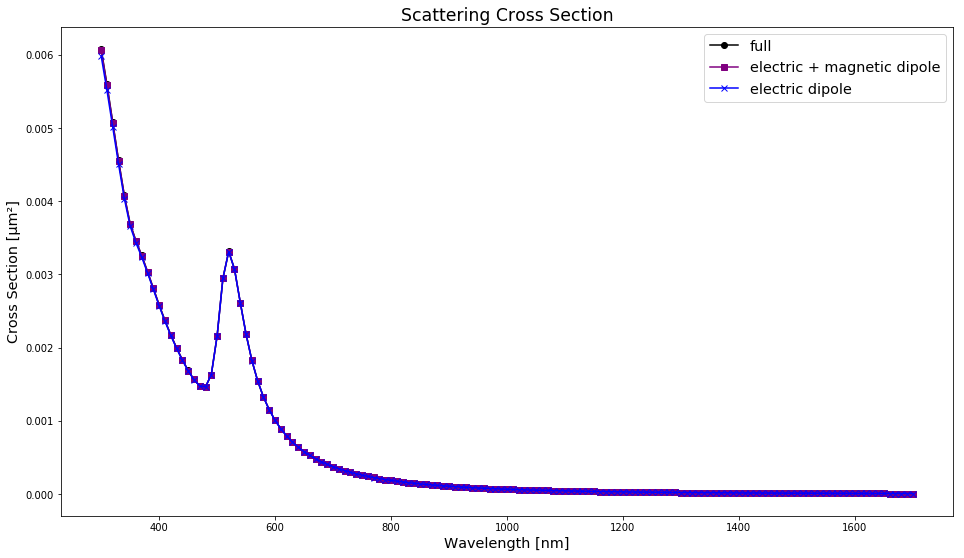

In [14]:
# Plot numerical and analytical cross-sections

fig, ax = plt.subplots(1,1,figsize=(16, 9))

ax.plot(ref_lam * 1000, sca_cross_section, linestyle='-', marker = 'o', color = 'k', label = 'full')
ax.plot(ref_lam * 1000, sca_cross_section_an, linestyle='-', marker = 's', color = 'purple', label = 'electric + magnetic dipole')
ax.plot(ref_lam * 1000, sca_cross_section_no_mag, linestyle='-', marker = 'x', color = 'b', label = 'electric dipole')

ax.set_xlabel('Wavelength [nm]', fontsize = 'x-large')
ax.set_ylabel('Cross Section [µm²]', fontsize = 'x-large')
ax.set_title('Scattering Cross Section', fontsize = 'xx-large')
#plt.xlim([300,600])
ax.legend(fontsize = 'x-large')

plt.savefig("cross_section_approximation_plot.pdf", format="pdf", bbox_inches="tight")

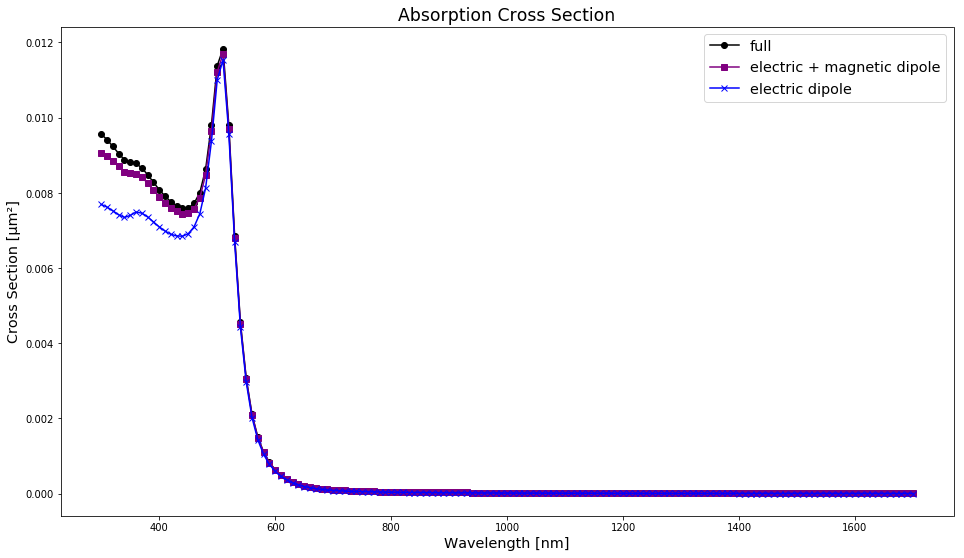

In [15]:
# Plot numerical and approximated analytical absorption cross-section 

fig, ax = plt.subplots(1,1,figsize=(16, 9))

ax.plot(ref_lam * 1000, abs_cross_section, linestyle='-', marker = 'o', color = 'k', label = 'full')
ax.plot(ref_lam * 1000, abs_cross_section_an, linestyle='-', marker = 's', color = 'purple', label = 'electric + magnetic dipole') 
ax.plot(ref_lam * 1000, abs_cross_section_no_mag, linestyle='-', marker = 'x', color = 'b', label = 'electric dipole') 

ax.set_xlabel('Wavelength [nm]', fontsize = 'x-large')
ax.set_ylabel('Cross Section [µm²]', fontsize = 'x-large')
ax.set_title('Absorption Cross Section', fontsize = 'xx-large')
ax.legend(fontsize = 'x-large')

plt.savefig("absorption_approximation_plot.pdf", format="pdf", bbox_inches="tight")

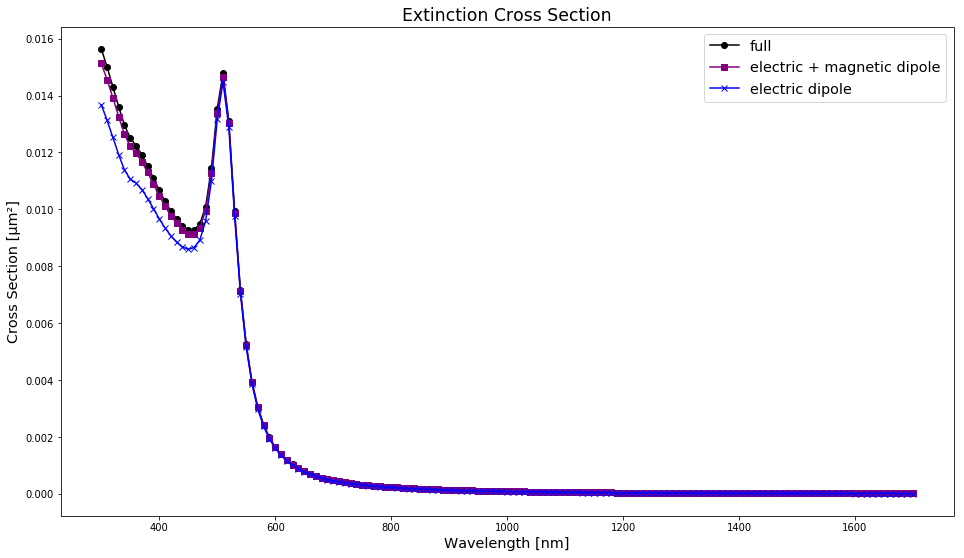

In [16]:
# Plot numerical and approximated analytical extinction cross-section 

fig, ax = plt.subplots(1,1,figsize=(16, 9))

ax.plot(ref_lam * 1000, ext_cross_section, linestyle='-', marker = 'o', color = 'k', label = 'full')
ax.plot(ref_lam * 1000, ext_cross_section_an, linestyle='-', marker = 's', color = 'purple', label = 'electric + magnetic dipole') 
ax.plot(ref_lam * 1000, ext_cross_section_no_mag, linestyle='-', marker = 'x', color = 'b', label = 'electric dipole') 

ax.set_xlabel('Wavelength [nm]', fontsize = 'x-large')
ax.set_ylabel('Cross Section [µm²]', fontsize = 'x-large')
ax.set_title('Extinction Cross Section', fontsize = 'xx-large')
ax.legend(fontsize = 'x-large')

plt.savefig("extinction_approximation_plot.pdf", format="pdf", bbox_inches="tight")

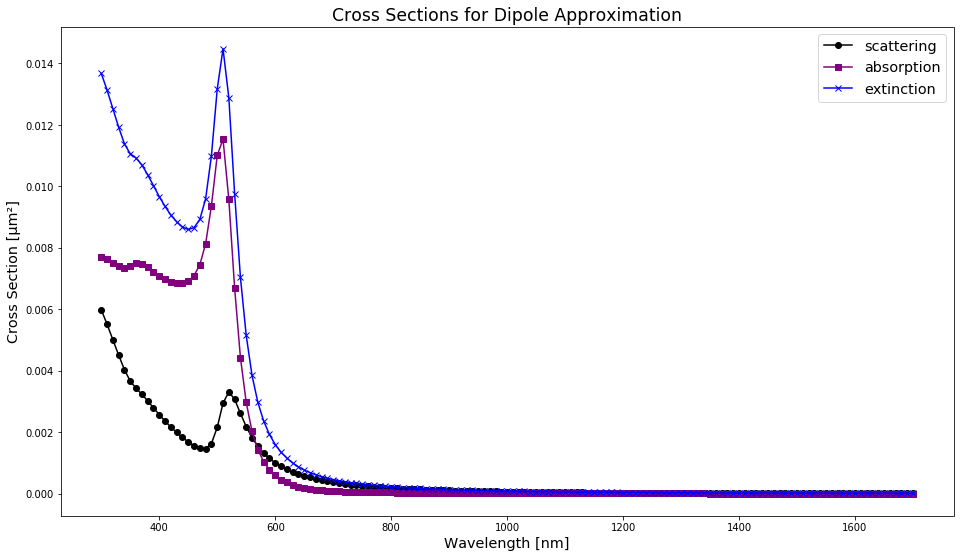

In [17]:
# Plot numerical and approximated analytical extinction cross-section 

fig, ax = plt.subplots(1,1,figsize=(16, 9))

ax.plot(ref_lam * 1000, sca_cross_section_no_mag, linestyle='-', marker = 'o', color = 'k', label = 'scattering')
ax.plot(ref_lam * 1000, abs_cross_section_no_mag, linestyle='-', marker = 's', color = 'purple', label = 'absorption') 
ax.plot(ref_lam * 1000, ext_cross_section_no_mag, linestyle='-', marker = 'x', color = 'b', label = 'extinction') 

ax.set_xlabel('Wavelength [nm]', fontsize = 'x-large')
ax.set_ylabel('Cross Section [µm²]', fontsize = 'x-large')
ax.set_title('Cross Sections for Dipole Approximation', fontsize = 'xx-large')
#plt.xlim([300,600])
ax.legend(fontsize = 'x-large')

plt.savefig("dipole_cross_sections_plot.pdf", format="pdf", bbox_inches="tight")

## Electric Field Around Nanosphere

In [18]:
# All functions incorporate only the electric dipole term into Mie scattering calculations
# Spherical coordinates: rho, theta, phi, where rho is the radial unit vector rescaled by the wavenumber of the
# incident light

def max_a_1(refr_ind, lam_list, r):
    
    '''
    Finds a_1 coefficient from the Mie scattering formalism that corresponds to the wavelength of maximum scattering.
    
    refr_ind - list of refractive indices [dimensionless]
    lam_list - list of wavelengths that have refr_ind [m]
    r - radius of particle [m]
    '''
    
    a_1_array = a_1_list(refr_ind,lam_list,r)
    '''
    # Include magnetic dipole term
    b_1_array = b_1_list(refr_ind,lam,r)
    sca_cross_section_an = sca_cross_section_analytical(a_1, b_1_array, ref_lam)
    max_sca = sca_cross_section_an.max()
    index = np.where(sca_cross_section_an == max_sca)
    
    a_1_max = a_1_array[index]
    mod_a_1_max = np.abs(a_1_max)
    '''
    sca_cross_section_no_mag = sca_cross_section_analytical(a_1_array, 0, lam_list) # no magnetic terms
    
    max_sca = sca_cross_section_no_mag.max()
    index = np.where(sca_cross_section_no_mag == max_sca)
    
    a_1_max = a_1_array[index]
    
    mod_a_1_max = np.abs(a_1_max)
    
    return mod_a_1_max

def max_lam(refr_ind, lam_list, r):
    
    '''
    Finds wavelength from input list for which scattering by the nanoparticle is maximum. 
    
    refr_ind - list of refractive indices [dimensionless]
    lam_list - list of wavelengths that have refr_ind [m]
    r - radius of particle [m]
    '''
    
    a_1_array = a_1_list(refr_ind,lam_list,r)
    sca_cross_section_no_mag = sca_cross_section_analytical(a_1_array, 0, lam_list)
    max_sca = sca_cross_section_no_mag.max()
    index = np.where(sca_cross_section_no_mag == max_sca)
    lam_max = lam_list[index]
    
    return lam_max 

def spherical_coords(x, y, z, lam_max, n = 1): #lam_max = wavelength for maximum scattering
    
    '''
    Transforms Cartesian coordinates into spherical coordinates.
    
    x,y,z - input coordinates [m]
    lam_max - incident wavelength [m] 
    n - index of refraction of surrounding medium; vacuum by default [dimensionless]
    '''
        
    k = wavenumber(lam_max, n)  
    radius_coord = np.sqrt(x**2 + y**2 + z**2)
    
    rho = k*radius_coord      
    theta = np.arctan(np.sqrt(x**2 + y**2)/z)
    phi = np.arctan(y/x)
    
    return rho, theta, phi

# Define components of scattered field in spherical coordinates

def E_radial(x, y, z, lam_max, a_1_max, n = 1): 
    
    '''
    Finds normalised radial component (E_r / E_0) of scattered field in spherical coordinates. [in Joules]
    
    x,y,z - input Cartesian coordinates [m]
    lam_max - incident wavelength [m] 
    a_1_max - a_1 coefficient for incident lam_max [dimensionless]
    n - index of refraction of surrounding medium; vacuum by default [dimensionless]
    '''
    
    rho, theta, phi = spherical_coords(x, y, z, lam_max, n)
    E_r = 3 * a_1_max * np.sqrt(np.pi/(2*rho)) * (sp.jv(3/2,rho) + 1j * sp.yv(3/2,rho)) * np.cos(phi) * np.sin(theta) / rho
    
    return E_r 

def E_theta(x, y, z, lam_max, a_1_max, n = 1): 
    
    '''
    Finds normalised theta component (E_theta / E_0) of scattered field in spherical coordinates. [in Joules]
    
    x,y,z - input Cartesian coordinates [m]
    lam_max - incident wavelength [m] 
    a_1_max - a_1 coefficient for incident lam_max [dimensionless]
    n - index of refraction of surrounding medium; vacuum by default [dimensionless]
    '''
    
    rho, theta, phi = spherical_coords(x, y, z, lam_max, n)
    
    hankel1_2 = sp.jv(1/2, rho) + 1j*sp.jv(1/2, rho)
    hankel3_2 = sp.jv(3/2, rho) + 1j*sp.jv(3/2, rho)

    E_theta = (3/2) * a_1_max * np.sqrt(np.pi/(2*rho)) * np.cos(phi) * np.cos(theta) * (hankel1_2 - hankel3_2/rho)
    
    return E_theta

def E_phi(x, y, z, lam_max, a_1_max, n = 1):  
    
    '''
    Finds normalised phi component (E_phi / E_0) of scattered field in spherical coordinates. [in Joules]
    
    x,y,z - input Cartesian coordinates [m]
    lam_max - incident wavelength [m] 
    a_1_max - a_1 coefficient for incident lam_max [dimensionless]
    n - index of refraction of surrounding medium; vacuum by default [dimensionless]
    '''

    rho, theta, phi = spherical_coords(x, y, z, lam_max, n)
    
    hankel1_2 = sp.jv(1/2, rho) + 1j*sp.jv(1/2, rho)
    hankel3_2 = sp.jv(3/2, rho) + 1j*sp.jv(3/2, rho)
    
    E_phi = (-3/2) * a_1_max * np.sqrt(np.pi/(2*rho)) * np.sin(phi) * (hankel1_2 - hankel3_2/rho)
    
    return E_phi

# Input Cartesian coordinates, output components of scattered field in spherical coordinates

def scattered_field_spherical(x, y, z, refr_ind, lam_max, r, a_1_max, n = 1): 
    
    '''
    Outputs all three normalised components of scattered field in spherical coordinates. [in Joules]
    
    x,y,z - input Cartesian coordinates [m]
    refr_ind - list of refractive indices [dimensionless]
    lam_max - incident wavelength [m] 
    a_1_max - a_1 coefficient for incident lam_max [dimensionless]
    n - index of refraction of surrounding medium; vacuum by default [dimensionless]
    '''
    
    E_r = E_radial(x, y, z, lam_max, a_1_max, n)
    E_th = E_theta(x, y, z, lam_max, a_1_max, n)
    E_ph = E_phi(x, y, z, lam_max, a_1_max, n)
    
    return E_r, E_th, E_ph   # all in terms of rho, theta, phi

In [19]:
def scattered_field_cartesian(x, y, z, refr_ind, lam_list, r, lam_value = None, n = 1):
    
    '''
    Outputs normalised components of scattered field in Cartesian coordinates. [in Joules]
    
    x,y,z - input Cartesian coordinates [m]
    refr_ind - list of refractive indices [dimensionless]
    lam_list - list of wavelengths corresponding to refr_ind [m]
    r - radius of particle [m]
    lam_value - incident wavelength from list of wavelengths [m]
                If lam_value is omitted, the code computes components of scattered field for the frequency 
                of maximum scattering.
    n - index of refraction of surrounding medium; vacuum by default [dimensionless]
    '''

    if lam_value == None:
        # Find parameters at resonance
        a_1_max = max_a_1(refr_ind, lam_list, r)
        lam_max = max_lam(refr_ind, lam_list, r)
    else:
        index = np.where(ref_lam == lam_value)
        m_value = refr_ind[index]
        a_1_max = a_1_list(m_value, lam_value, r)
        lam_max = lam_value #* 0.000001 # rescale from micrometers to nanometers

    E_r, E_th, E_ph = scattered_field_spherical(x, y, z, refr_ind, lam_max, r, a_1_max, n)
    
    rho, theta, phi = spherical_coords(x, y, z, lam_max, n)
    
    E_x = E_r * np.sin(theta) * np.cos(phi) + E_th * np.cos(theta) * np.cos(phi) - E_ph * np.sin(phi)
    E_y = E_r * np.sin(theta) * np.sin(phi) + E_th * np.cos(theta) * np.sin(phi) + E_ph * np.cos(phi)
    E_z = E_r * np.cos(theta) - E_th * np.sin(theta)
    
    return E_x, E_y, E_z

# Find normalised absolute value of field at given point (x,y,z)

def scattered_field_absolute(x, y, z, refr_ind, lam_list, r, lam_value = None, n = 1):
    
    '''
    Calculates the absolute value of the scattered field at an input point (x,y,z). [in Joules]
    
    x,y,z - input Cartesian coordinates [m]
    refr_ind - list of refractive indices [dimensionless]
    lam_list - list of wavelengths corresponding to refr_ind [m]
    r - radius of particle [m]
    lam_value - incident wavelength from list of wavelengths [m]
                If lam_value is omitted, the code computes components of scattered field for the frequency 
                of maximum scattering.
              
    n - index of refraction of surrounding medium; vacuum by default [dimensionless]
    '''
    
    E_x, E_y, E_z = scattered_field_cartesian(x, y, z, refr_ind, lam_list, r, lam_value, n)

    E = np.sqrt(np.abs(E_x)**2 + np.abs(E_y)**2 + np.abs(E_z)**2)
    
    return E

## Plotting Scattered Field ( + txt File with Field Values)

In [20]:
def plot_scattered_field(x_points, y_points, z, refr_ind, lam_list, r, filename = 'defaultFile.txt', 
                         lam_value = None, n = 1): 
    
    '''
    Function calculates normalised scattered field along a cross section of the nanosphere. It outputs a txt file 
    with field values for the different coordinates, and a plot of the cross section.
    
    x_points, y_points - arrays of points for which scattering is calculated [nm]
    z - fixed coordinate that defines the plane of cross section [nm]
    
    refr_ind - list of refractive indices 
    lam_list - list of wavelengths corresponding to refr_ind, in [μm]
    r - radius of particle [μm]
    filename - name for txt file with coordinates and field values that the function will create
    lam_value - specific wavelength of the incident light; must be in the list of wavelengths [μm]
                If lam_value is omitted, the scattering is performed at the frequency of maximum scattering.
    n - index of refraction of surrounding medium; vacuum by default
    '''
    
    # Rescale coordinates to meters
    x_points = x_points * 0.000000001
    y_points = y_points * 0.000000001
    z = z * 0.000000001

    if lam_value != None:
        if lam_value not in lam_list:
            print("Refractive index for this wavelength is not known. Please, choose wavelength from the input list of wavelengths.")
    
    # Rescale input parameters to meters
    lam_list = lam_list * 0.000001
    r = r * 0.000001
    
    # Create txt file with coordinate values
    f = open(filename,'w')
    f.write("# X [nm] , Y [nm], E/E_0 \n")
    coord = []
    
    # Build arrays of points and scattered fields
    colors = np.array([])
    points_x = []
    points_y = []
    
    for j in y_points:
        for i in x_points:
            if i**2 + j**2 < r**2:
                E = [0]
            else:
                E = scattered_field_absolute(i,j,z,refr_ind,lam_list,r,lam_value,n) # in Joules
            points_x.append(1000000000*i) # rescale to nm for plot
            points_y.append(1000000000*j) # rescale to nm for plot
            colors = np.append(colors, E)
            
            c = [1000000000*i , 1000000000*j , *E]  # coordinates for txt file
            coord.append(c)
            
    # Plot
    fig, ax = plt.subplots(1,1, figsize = (10, 10))
    plt.scatter(points_y, points_x, c=colors, cmap='jet')
    plt.xlabel('X [nm]')
    plt.ylabel('Y [nm]')
    plt.title('Scattered field in X-Y plane')


    cbar = plt.colorbar(shrink = 0.6)
    cbar.ax.set_title(r'$|E|/|E_0|$')

    ax.set_aspect('equal')

    plt.show()
    plt.savefig("scattered_field_plot.pdf", format="pdf", bbox_inches="tight")
    
    # Write the coordinates in the txt file
    csv.writer(f, delimiter=',').writerows(coord)
    f.close()
    
    # Return values

    if lam_value == None:
        wavelength = f'At incoming wavelength of {1000000000 * max_lam(refr_ind, lam_list, r)} nm'
    else:
        wavelength = f'At incoming wavelength of {1000 * lam_value} nm'
    E_max = f'Maximum scattered field = {colors.max()} E_0'
    
    return wavelength, E_max

/home/niya/.local/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in double_scalars
/home/niya/.local/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: divide by zero encountered in double_scalars


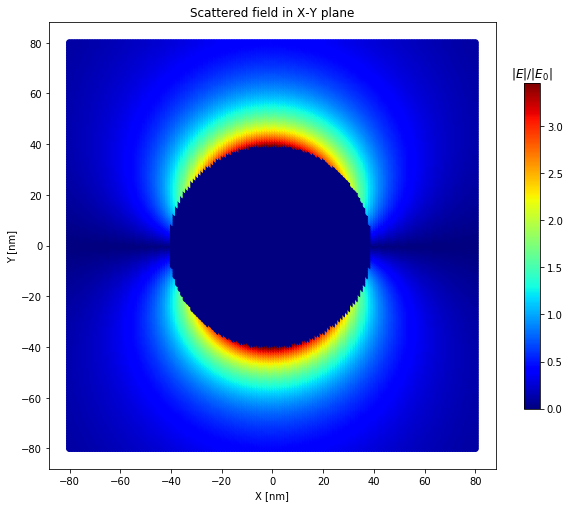

('At incoming wavelength of 510.0 nm',
 'Maximum scattered field = 3.4622508991258636 E_0')

In [21]:
x_points = np.arange(-80, 81, 1)   # in nm
y_points = np.arange(-80, 81, 1)   # in nm
z = 0 # in nm

plot_scattered_field(x_points, y_points, z, m, ref_lam, a, filename = 'coordinates.txt', lam_value = 0.51)

## Another Visualisation Design

In [22]:
# From https://physics.itmo.ru/en/mie#/nearfield

data = np.genfromtxt('coordinates.txt', names=True, delimiter=',')
x = data[data.dtype.names[0]] 
y = data[data.dtype.names[1]]
x_size = len(np.unique(x))
y_size = len(np.unique(y))
x_min = np.min(x)
y_min = np.min(y)
x_max = np.max(x)
y_max = np.max(y)
dx = (x_max-x_min)/(x_size-1)
dy = (y_max-y_min)/(y_size-1)
E = data['E/E_0 '].reshape((y_size,x_size))

plt.figure()
plt.imshow(E, cmap='jet', origin='lower',
           extent=(x_min-dx/2, x_max+dx/2, y_min-dy/2, y_max+dy/2))
cbar = plt.colorbar(shrink=0.7)
cbar.ax.set_title(r'$|E|/|E_0|$')
plt.xlabel(data.dtype.names[0].replace('_',', '))
plt.ylabel(data.dtype.names[1].replace('_',', '))
fig = plt.gcf()
ax = fig.gca()
radius = 40 #nm
ax.add_patch(plt.Circle((0, 0), radius, color='darkblue', lw=3))
plt.title('Ek cross-section')
plt.show()


ValueError: no field of name E/E_0 